# Ingest gene expression data from TCGA, TARGET and GTEX

Download gene expression data from the [UCSC Xena Toil re-compute dataset](https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net), wrangle, enrich and store in an hdf5 file for machine learning. This dataset comprises gene expression data for nineteen thousand samples  processed using the same genomics pipeline and therefore comparable to each other. 

Each sample consists of a float32 vector, log2(norm count + 1) normalized, of gene expression for each of ~60k genes. Associated with these data is clinical information on each sample such as type (tumor vs. normal), primary site (where the sample came from in the human body) etc... We use this information to label the samples normal/0 vs. tumor/1 as well as to provide additional information for visualization and interpretation of models. 

The resulting hdf5 file, tumornormal.h5, contains the following datasets:

* **X_train, X_test:** float32 gene expression train/test sets split via stratification on class (primary site)
* **y_train, y_test:** Binary 0=Normal, 1=Tumor label for binary classification machine learning
* **features:** Hugo gene names for each feature in X
* **labels:** Labels for y binary values ie "Normal" = 0 and "Tumor" = 1
* **classes_train, classes_test:** Class id (integer) for each sample - useful for visualization when clustering
* **class_labels:** Text corresponding to each class id (ie disease) - useful as legend when visualizing

In [2]:
import os
import requests
import numpy as np
import pandas as pd
import h5py

In [3]:
%%time
"""
Download expression data from Xena and save in an hdf5 file. This can take around 
30 minutes between the download and the conversion from tsv into float32 dataframes
We download manually vs. passing read_csv a url directly as the latter times
out with this size file. Note we invert the expression matrix to conform 
to machine learning where rows are samples vs. gene expression files where 
rows are features (gene, transcript, or variant) and columns are 
instances (per sample or cell expression levels)
"""
if not os.path.exists("data"):
    os.makedirs("data")
    
if not os.path.exists("data/TcgaTargetGtex_RSEM_Hugo_norm_count.gz"):
    print("Downloading TCGA, TARGET and GTEX expression data from UCSC Xena")
    r = requests.get("https://toil.xenahubs.net/download/TcgaTargetGtex_RSEM_Hugo_norm_count.gz")
    r.raise_for_status()
    with open("data/TcgaTargetGtex_RSEM_Hugo_norm_count.gz", "wb") as f:
        for chunk in r.iter_content(32768):
            f.write(chunk)

if not os.path.exists("data/TcgaTargetGtex_RSEM_Hugo_norm_count.hd5"):
    print("Converting expression to dataframe and storing in hdf5 file")
    expression = pd.read_csv("data/TcgaTargetGtex_RSEM_Hugo_norm_count.gz", 
                             sep="\t", index_col=0).dropna().astype(np.float32).T
    expression.to_hdf("data/TcgaTargetGtex_RSEM_Hugo_norm_count.hd5", "expression", mode="w", format="fixed")

X = pd.read_hdf("data/TcgaTargetGtex_RSEM_Hugo_norm_count.hd5", "expression").sort_index(axis=0)
print("X: samples={} genes={}".format(*X.shape))

X: samples=19249 genes=58581
CPU times: user 2.08 s, sys: 8.05 s, total: 10.1 s
Wall time: 43.8 s


In [4]:
X.head()

sample,CTD-2588J6.1,RP11-433M22.1,CTD-2588J6.2,RP3-415N12.1,RP11-16E12.2,RP11-433M22.2,PSMA2P3,RP11-181G12.4,RP11-181G12.2,AC007272.3,...,RP11-390F4.3,GNGT2,GNGT1,SELT,DIAPH2-AS1,SELV,NFIX,SELP,AC002386.1,RP11-526P5.2
GTEX-1117F-0226-SM-5GZZ7,0.0000,1.2696,0.0,1.2696,4.8689,0.0,0.0,1.2696,6.1028,0.0000,...,2.3876,3.7760,0.0,10.3881,1.9343,0.0,13.0493,7.2742,0.0,0.0
GTEX-1117F-0426-SM-5EGHI,0.0000,0.0000,0.0,1.7360,0.0000,0.0,0.0,0.0000,5.3444,0.9329,...,2.5013,3.6616,0.0,11.3261,0.0000,0.0,13.7404,6.1483,0.0,0.0
GTEX-1117F-0526-SM-5EGHJ,1.4634,0.0000,0.0,2.1747,3.5292,0.0,0.0,0.0000,6.5568,0.0000,...,2.6490,3.0054,0.0,11.0126,1.4634,0.0,13.0419,8.3337,0.0,0.0
GTEX-1117F-0626-SM-5N9CS,2.2652,0.0000,0.0,2.2652,3.3050,0.0,0.0,1.1821,6.0383,0.7746,...,0.0000,4.9159,0.0,11.0222,3.4793,0.0,12.2229,8.5076,0.0,0.0
GTEX-1117F-0726-SM-5GIEN,0.0000,0.0000,0.0,1.5589,4.6061,0.0,0.0,0.0000,5.7943,1.0499,...,4.3549,5.0063,0.0,10.7896,2.2905,0.0,12.3862,7.9092,0.0,0.0


In [5]:
# Read in the sample labels from Xena ie clinical/phenotype information on each sample
if not os.path.exists("data/TcgaTargetGTEX_phenotype.txt.gz"):
    with open("data/TcgaTargetGTEX_phenotype.txt.gz", "wb") as f:
        f.write(requests.get("https://toil.xenahubs.net/download/TcgaTargetGTEX_phenotype.txt.gz").content)

Y = pd.read_table("data/TcgaTargetGTEX_phenotype.txt.gz", compression="gzip",
                  header=0, names=["id", "category", "disease", "primary_site", "sample_type", "gender", "study"],
                  sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str").sort_index(axis=0)

# Compute and add a tumor/normal column - TCGA and TARGET have some normal samples, GTEX is all normal.
Y["tumor_normal"] = Y.apply(
    lambda row: "Normal" if row["sample_type"] in ["Cell Line", "Normal Tissue", "Solid Tissue Normal"]
    else "Tumor", axis=1)

Y[0:100:4000].head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal


In [6]:
Y.describe()

,category,disease,primary_site,sample_type,gender,study,tumor_normal
count,19130,19130,19126,19131,18972,19131,19131
unique,93,93,46,17,2,3,2
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor
freq,1212,1212,1846,9185,10456,10535,10531


In [7]:
# Use the tissue location as the class label for the purposes of stratification
class_attribute = "primary_site"

# Tumor vs. Normal is the binary attribute we'll use to train on
label_attribute = "tumor_normal"

In [8]:
# Remove rows where the class is null or the sample is missing
Y_not_null = Y[pd.notnull(Y[class_attribute])]
intersection = X.index.intersection(Y_not_null.index)
X_clean = X[X.index.isin(intersection)]
Y_clean = Y[Y.index.isin(intersection)]

# Make sure the label and example samples are in the same order
assert(X_clean.index.equals(Y_clean.index))

print(intersection.shape[0], "samples with non-null labels")

19115 samples with non-null labels


In [9]:
# Convert tumor/normal labels to binary 1/0
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_binary = encoder.fit_transform(Y_clean["tumor_normal"])

In [10]:
# Convert classes into numbers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(Y_clean[class_attribute].values)
classes = encoder.transform(Y_clean[class_attribute])
print("Total classes for stratification:", len(set(classes)))
class_labels = encoder.classes_

Total classes for stratification: 46


In [14]:
%%time
# Split into stratified training and test sets based on classes (i.e. tissue type) so that we have equal
# proportions of each tissue type in the train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_clean.values, Y_clean[class_attribute]):
    X_train, X_test = X.values[train_index], X_clean.values[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    classes_train, classes_test = classes[train_index], classes[test_index]

CPU times: user 2.24 s, sys: 1.57 s, total: 3.81 s
Wall time: 3.81 s


In [12]:
"""
Write to an h5 file for training (see above for details on each dataset)
"""
with h5py.File("data/tumor_normal.h5", "w") as f:
    f.create_dataset('X_train', X_train.shape, dtype='f')[:] = X_train
    f.create_dataset('X_test', X_test.shape, dtype='f')[:] = X_test
    f.create_dataset('y_train', y_train.shape, dtype='i')[:] = y_train
    f.create_dataset('y_test', y_test.shape, dtype='i')[:] = y_test
    f.create_dataset('classes_train', y_train.shape, dtype='i')[:] = classes_train
    f.create_dataset('classes_test', y_test.shape, dtype='i')[:] = classes_test
    f.create_dataset('features', X_clean.columns.shape, 'S10', 
                     [l.encode("ascii", "ignore") for l in X_clean.columns.values])
    f.create_dataset('labels', (2, 1), 'S10', 
                     [l.encode("ascii", "ignore") for l in ["Normal", "Tumor"]])
    f.create_dataset('class_labels', (len(class_labels), 1), 'S10', 
                     [l.encode("ascii", "ignore") for l in class_labels])

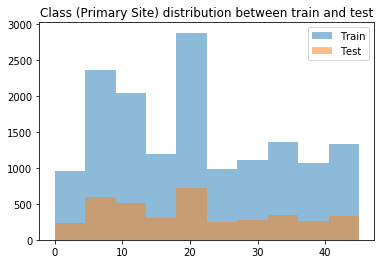

In [13]:
import matplotlib.pyplot as pyplot
pyplot.hist(classes_train, alpha=0.5, label='Train')
pyplot.hist(classes_test, alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Class (Primary Site) distribution between train and test")
pyplot.show()